# Deep Supervised Classification

In [1]:
from src.skeleton import BaseModel

### 샘플 데이터셋 생성

In [2]:
from src.utils.data_utils import TwoMoonDataset
import torch

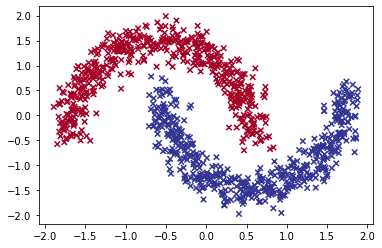

In [3]:
import matplotlib.pyplot as plt
train_dataset = TwoMoonDataset(1000, noise=(0.1,0.1), n_label=1000)
test_dataset = TwoMoonDataset(1000, noise=(0.1,0.1), n_label=1000)
X = train_dataset.X
y = train_dataset.y
M = train_dataset.M

plt.scatter(X[:,0], X[:,1], c=y, s=30, marker='x', cmap='RdYlBu')
plt.show()

In [4]:
print(len(train_dataset), len(test_dataset))

1000 1000


## !!! Deep Supervised Classification 모델 생성
- ```__init__()``` method에서 모델의 layer 정의
- ```forward()``` method에서 모델의 forward pass 정의
    - output 형태 : (batch, **n_class**)
- ```criterion()``` method에서 모델의 loss 함수 정의
- ```compute_score()``` method에서 예측 accuracy 측정

In [5]:
import torch.nn as nn
class MyModel(BaseModel):
    def __init__(self, in_dim, out_dim, model_name='my_model'):
        super().__init__(model_name=model_name)
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, batch, label=None, mask=None):
        x = self.fc1(batch)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        if mask.sum() == 0:
            return None
        return nn.CrossEntropyLoss()(pred[mask], label[mask])
    
    def compute_score(self, pred=None, batch=None, label=None, mask=None):
        #print('compute_score input : ', pred.shape)
        pred_cls = torch.argmax(pred, dim=1)
        correct = (pred_cls[mask]==label[mask]).sum()
        return correct / (label[mask].shape[0]+1e-10)

#### 배치 사이즈 (BATCH), 에폭 수 (EPOCH), learning rate (LR) 정의

In [6]:
BATCH = 1000
EPOCH = 100
LR = 1e-2

train, test DataLoader 생성 (train DataLoader만 shuffle)

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)

모델 생성 및 CUDA로 이동

In [8]:
model = MyModel(2, 2)
model.cuda()

MyModel(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)

optimizer 생성

In [9]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR)

#### ```train_model()``` method를 통해 모델 학습

In [10]:
model.train_model(train_loader, test_loader, EPOCH, optimizer, report_intv=10)

(0.29s) [Epoch 1]
	Train Loss : 0.68183	Train Score : 0.683
	Eval Loss : 0.3292	Eval Score : 0.859
(0.01s) [Epoch 11]
	Train Loss : 0.072654	Train Score : 0.984
	Eval Loss : 0.061215	Eval Score : 0.994
(0.05s) [Epoch 21]
	Train Loss : 0.0040695	Train Score : 1
	Eval Loss : 0.0032093	Eval Score : 1
(0.01s) [Epoch 31]
	Train Loss : 0.00095296	Train Score : 1
	Eval Loss : 0.00094559	Eval Score : 1
(0.01s) [Epoch 41]
	Train Loss : 0.00045729	Train Score : 1
	Eval Loss : 0.00045904	Eval Score : 1
(0.01s) [Epoch 51]
	Train Loss : 0.00028115	Train Score : 1
	Eval Loss : 0.00027305	Eval Score : 1
(0.01s) [Epoch 61]
	Train Loss : 0.00019884	Train Score : 1
	Eval Loss : 0.00019016	Eval Score : 1
(0.01s) [Epoch 71]
	Train Loss : 0.00014547	Train Score : 1
	Eval Loss : 0.00014047	Eval Score : 1
(0.01s) [Epoch 81]
	Train Loss : 0.00010954	Train Score : 1
	Eval Loss : 0.00010685	Eval Score : 1
(0.01s) [Epoch 91]
	Train Loss : 8.7923e-05	Train Score : 1
	Eval Loss : 8.6387e-05	Eval Score : 1


# 결과 분석

[Epoch 1]


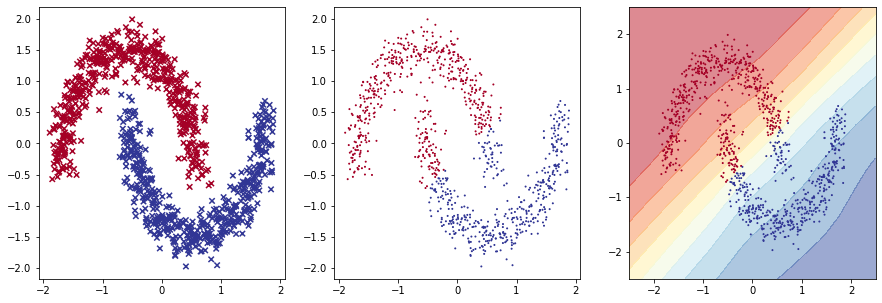

[Epoch 11]


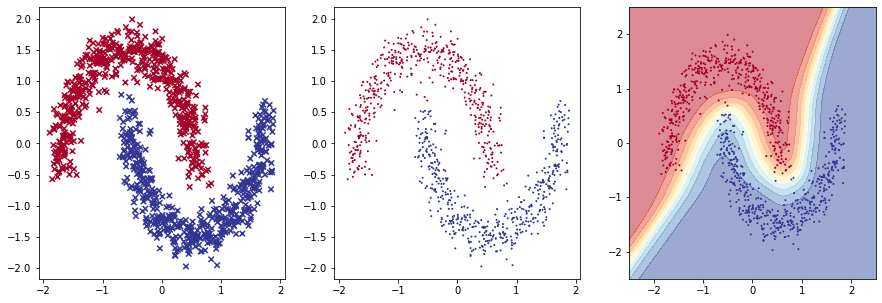

[Epoch 21]


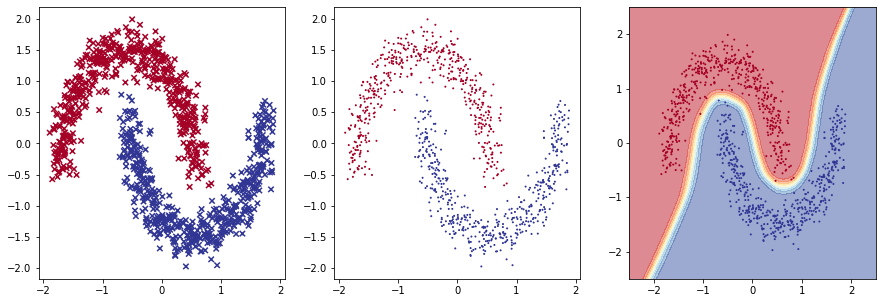

[Epoch 31]


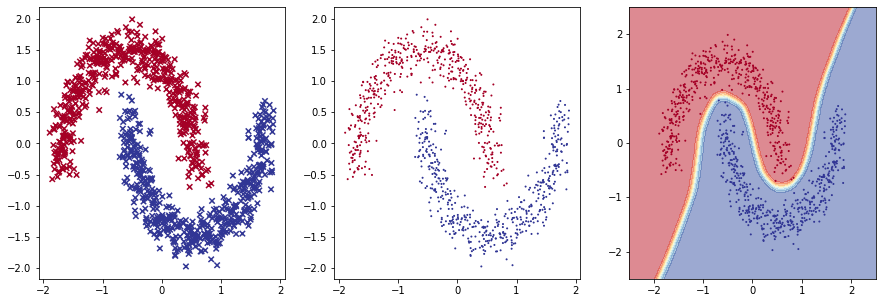

[Epoch 41]


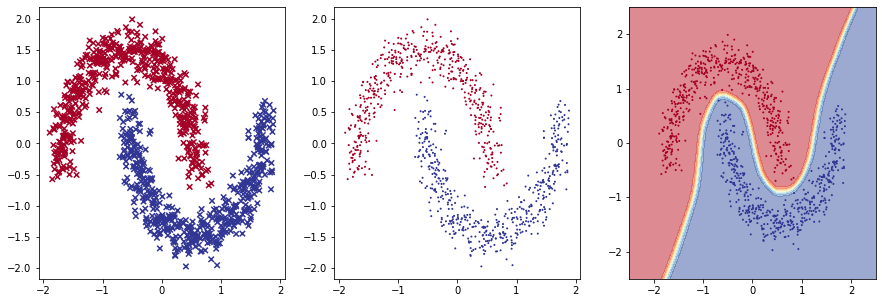

[Epoch 51]


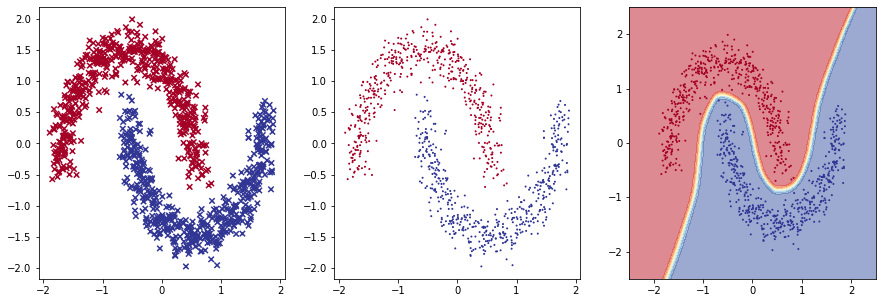

[Epoch 61]


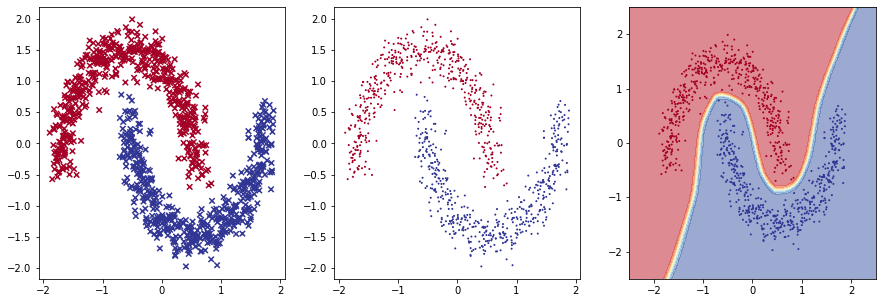

[Epoch 71]


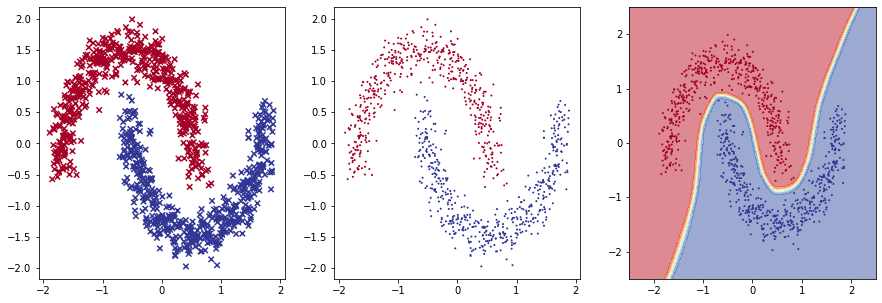

[Epoch 81]


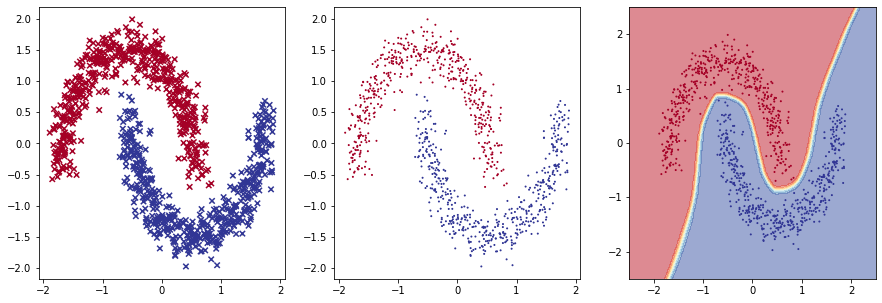

[Epoch 91]


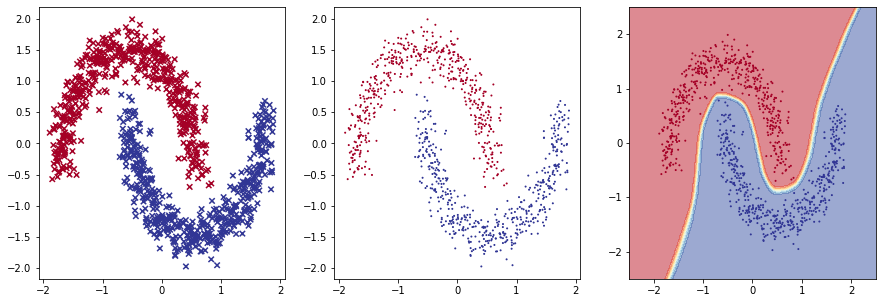

In [11]:
import numpy as np

a=np.linspace(-2.5,2.5,100)
x_grid,y_grid = np.meshgrid(a,a)
x_grid=x_grid.reshape(-1)
y_grid=y_grid.reshape(-1)

grid_dataloader = DataLoader([(torch.tensor([x_grid[i],y_grid[i]]),0,True) for i in range(x_grid.shape[0])], batch_size=BATCH)


for e in range(0,100,10):
    model = MyModel(2,2)
    model.load_state_dict(torch.load('./saved_models/my_model_e%d.pth'%(e+1)))
    print('[Epoch %d]'%(e+1))
    model.cuda()
    with torch.no_grad():
        pred=model.predict(test_loader)
        pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = test_dataset.X
    y = test_dataset.y
    M = test_dataset.M

    fig=plt.figure(figsize=(15,5))
    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()
